In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from timer import Timer

from dataclasses import dataclass

In [3]:
videoCapture = cv2.VideoCapture("static.mp4")
images = []
while True:
    ret, frame = videoCapture.read()
    if not ret:
        break
    images.append(frame)

In [4]:
sift = cv2.SIFT_create()
kds = [sift.detectAndCompute(i, None) for i in images]
keypoints, descriptors = list(zip(*kds))
#kps = [np.array([j.pt for j in i]) for i in kps]

In [5]:
class ImagePair:
    i: int
    j: int
    kps: tuple[list[cv2.KeyPoint]]
    descs: tuple[np.ndarray]

    matches: list[cv2.DMatch] = None
    H: np.ndarray = None
    mask: list[int]

    def __init__(self, i, j, keypoints, descriptors):
        self.i = i
        self.j = j
        self.kps = (keypoints[i], keypoints[j])
        self.descs = (descriptors[i], descriptors[j])


image_pairs: list[ImagePair] = []
for i in range(len(images) - 1):
    p = ImagePair(i, i+1, keypoints, descriptors)
    image_pairs.append(p)

ki = 10
for i in range(0, len(images) - ki, ki):
    for j in range(i + ki, len(images) - ki, ki):
        p = ImagePair(i, j, keypoints, descriptors)
        image_pairs.append(p)


def findMatches(p: ImagePair, flann, thresh=50):
    matches = flann.knnMatch(p.descs[0], p.descs[1], k=2)
    goodMatches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            goodMatches.append(m)
    if len(goodMatches) < thresh:
        return None
    return goodMatches


In [6]:

flann = cv2.FlannBasedMatcher(
    indexParams={'algorithm': 1, 'trees': 5},
    searchParams={'checks': 50})

for p in image_pairs:
    p.matches = findMatches(p, flann)

image_pairs = [p for p in image_pairs if p.matches is not None]


In [7]:
for p in image_pairs:
    srcPts = np.float32([p.kps[0][m.queryIdx].pt for m in p.matches]
                        ).reshape(-1, 1, 2)
    dstPts = np.float32([p.kps[1][m.trainIdx].pt for m in p.matches]
                        ).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(srcPts, dstPts, cv2.RANSAC,
                               ransacReprojThreshold=5.0)
    if H is None:
        continue

    p.H = H
    p.mask = mask.ravel().tolist()

image_pairs = [p for p in image_pairs if p.H is not None]

In [8]:
pairs_map = {}
for p in image_pairs:
    pairs_map[(p.i, p.j)] = p


In [9]:
def visualize_H(src_img_shape, dst_img: np.ndarray, H: np.ndarray):
    dst_img = dst_img.copy()
    h, w = src_img_shape
    b, a = 0.05 * h, 0.05 * w
    r1 = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1, 1, 2)
    r2 = np.float32([[a,b],[a,h-b],[w-a,h-b],[w-a,b]]).reshape(-1, 1, 2)
    dr1 = cv2.perspectiveTransform(r1, H)
    dr2 = cv2.perspectiveTransform(r2, H)

    out = cv2.polylines(dst_img, [np.int32(dr1)], isClosed=True,
                        color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
    out = cv2.polylines(out, [np.int32(dr2)], isClosed=True,
                        color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
    return out

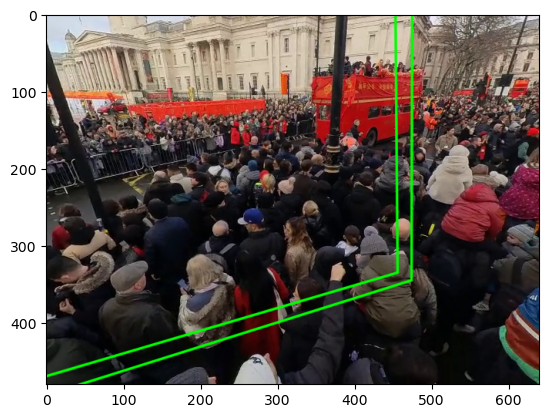

In [10]:
i, j = 0, 10
out = visualize_H((480, 640), images[j], pairs_map[(i,j)].H)
out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
plt.imshow(out)
plt.show()